# Exercise Session 3: Edge Detection and Delineation

## Introduction

In Google earth we can visualize 3D reconstructions of mountain
chains. An important feature to identify a mountain chain is its ridge (or edge) in the
image. Human vision is very good at detecting such structures but doing it automatically
using computer vision algorithms is not trivial. Here we will try to delineate the ridge of
a mountain as given in Fig. 1 using Dijkstra’s algorithm. Use 'mountain.png' inside folder images as input.

<figure>
  <img src="images/mountain.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; " />
    <img src="images/ridge.png" style="float: left; width: 36%;margin: 20px 40px 55px 85px; "/>
    <figcaption>Figure 1: (a) Input image. Start and end positions of the ridge are displayed on
the image. Pixel values for these positions are provided in the code. (b) Detected
ridge. Ridge is detected between the start and end points using Dijkstra’s algorithm
and overlayed on the image.</figcaption>
</figure>

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['image.cmap'] = 'gray'

## Computing gradients

We will first detect the edges in the image by simply computing the gradient image.
This will then be used in the next exercise session for ridge delineation.
* First read 'mountain.png' image and convert it to grayscale. 
* Smooth the images using a Gaussian
filter of size $7 \times 7$. Choose suitable $\sigma$. What is the trade-off of using bigger $\sigma$?
* Compute the gradients in x- and y-directions using Sobel mask.
* Compute a gradient-magnitude image.
* Threshold gradient image to find the most pronounced edges and store as ```th_grad_img```. Output should look like the figure below. To obtain the below image, you need to replace the pronounced edge pixels with their magnitude in the thresholded image. The colormap used for visualization is 'jet' (```plt.imshow(th_grad_img,cmap='jet')```)

<img src="images/threshgrad.png" style="float: left; width: 50%;margin: 20px 40px 55px 85px; " />

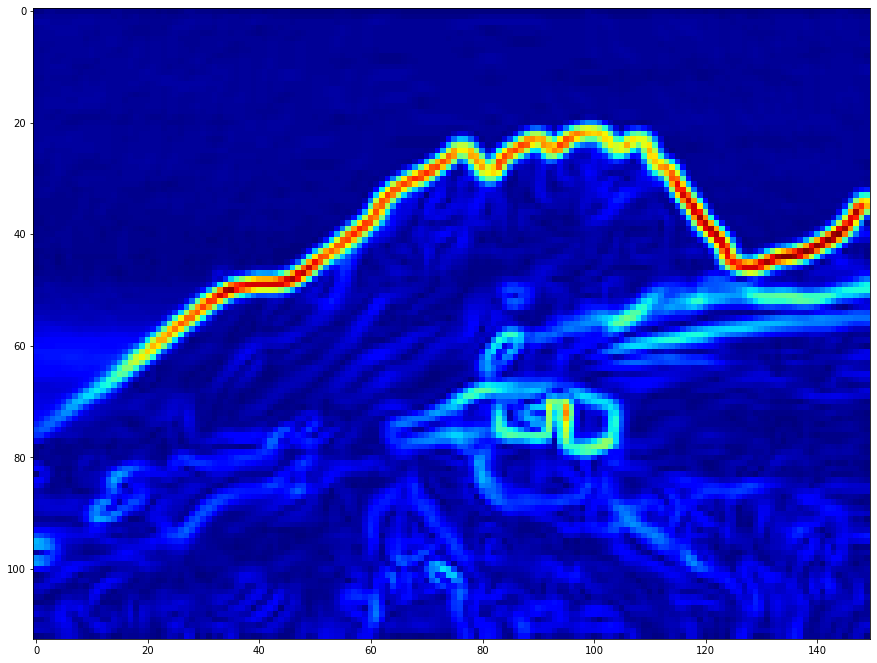

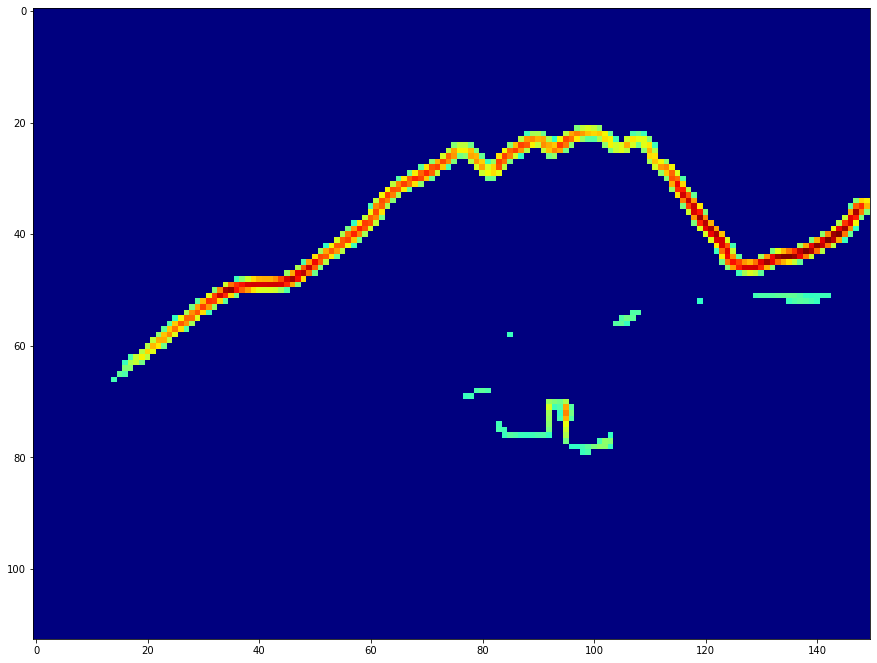

In [4]:
# Load image
mountain = cv2.imread('images/mountain.png', 0)

# Filter image
blurred_mountain = cv2.GaussianBlur(mountain, ksize=(7,7), sigmaX=1)
blurred_mountain = np.float32(blurred_mountain)

# Gradients using Sobel
sobel_x = cv2.Sobel(blurred_mountain,cv2.CV_64F,1,0,ksize=3)
sobel_y = cv2.Sobel(blurred_mountain,cv2.CV_64F,0,1,ksize=3)

# Gradient magnitude
magnitude = np.sqrt(np.power(sobel_x, 2) + np.power(sobel_y, 2))
plt.figure(1)
plt.imshow(magnitude, cmap='jet')

mountain_grad = magnitude > 150
threshold_mountain = mountain_grad * magnitude
plt.figure(2)
plt.imshow(threshold_mountain, cmap='jet')

## Delineating ridges

Given the thresholded gradient image computed in the previous exercise, we will now
delineate the ridge of a mountain using Dijkstra’s shortest path algorithm. Roughly
speaking, starting from an initial node, this algorithm looks around the neighboring
pixels and chooses the pixel with the shortest distance to the current pixel as the next
element of the path. Particularly, in this example, we will find the shortest paths from a
starting pixel to all the other pixels in the image. </br>
The distance of a pixel to a neighboring one can be defined by a cost value for the edge
connecting these two pixels. For this particular problem, we will define the cost of the
edge to pixel (i, j) from any of its 4-neighbors as ```cost(i,j) = C - thresholdedGrad(i, j)```,
where C is a constant and thresholdedGrad(i,j) is the value of the thresholded
gradient image at pixel (i, j). With such definition of cost, the algorithm will assign
low cost values to high gradient regions, which are typically the regions in the image
that belong to the ridges of the mountain, and therefore will choose pixels belonging
to mountain ridges as the next element in the shortest path. In the end, this would
effectively delineate the ridge of the mountain.
In particular, the steps of the algorithm can be summarized as follows:
1. Assign to every pixel a distance value: zero for the initial pixel and infinity for all
other pixels.
2. Set the initial pixel as current and mark it visited. All the other pixels are initially
unvisited. Create a set of all the visited pixels called the visited set (e.g., a binary
matrix of 1’s for visited pixels and 0’s for unvisited pixels).
3. For the current pixel, consider all of its unvisited neighbors and calculate their
distances. Use the edge cost defined above to measure the distance between a
pixel and its neighboring one. Compare the newly calculated tentative distance to
the current assigned value and assign the smaller one. For example, if the current
pixel is marked with a distance of 15, and the edge connecting it with a neighbor has value 2, then the distance between them will be 15 + 2 = 17. If the neighbor
was previously marked with a distance greater than 17 then change it to 17 and
update the previous pixel position. Otherwise, keep the current value.
4. When we are done considering all of the neighbors of the current pixel, mark the
current node as visited. A visited pixel will never be checked again.
5. Select the unvisited pixel that is marked with the smallest distance, set it as the
new "current pixel", and go back to step 3.
The algorithm will terminate when all the pixels in the image are visited.

### Computing the shortest path 

* Fill in the function
dijkstra to implement the above algorithm. The input to the function should be
respectively, the thresholded gradient image, the constant C, and starting position of
the ridge. The algorithm should return a distance matrix that encodes the shortest
path from the starting point to each pixel in the image and a matrix that stores for
each pixel the position of the previous pixel that lies on the shortest path to the
starting point.

In [5]:
def dijkstra(thresholded_grad, C, ridge_start_row, ridge_start_col):
    
    rows = thresholded_grad.shape[0]
    cols = thresholded_grad.shape[1]
    edge_costs = C - thresholded_grad
    
    # 1. Initialize every pixel's distance value
    distance_matrix = np.full((rows, cols), np.inf)
    distance_matrix[ridge_start_row, ridge_start_col] = 0
    
    # 2. Keep track of visited-so-far and previous pixel
    visited = np.zeros((rows,cols))
    previous = np.zeros((rows, cols, 2))
    
    while (np.any(visited == 0)):
        
        # looking for the unvisited pixel with shortest
        #      distance (set distance for visited pixels to infinity)
        curr_distance = distance_matrix.copy()
        curr_distance[visited == 1] = np.inf
        running_min_distance = np.min(curr_distance)
        
        # find index of the minimum distance in the distance matrix and unravel the coordinates
        cur_position = np.argmin(curr_distance, axis=None)
        cur_row, cur_col = np.unravel_index(cur_position, curr_distance.shape)
        visited[cur_row, cur_col] = 1
        
        # update left neighboring pixel
        if (cur_row > 0 and (visited[cur_row - 1, cur_col] == 0)
            and (distance_matrix[cur_row - 1, cur_col] > running_min_distance + edge_costs[cur_row - 1, cur_col])):
            previous[cur_row - 1, cur_col, 0] = cur_row
            previous[cur_row - 1, cur_col, 1] = cur_col
            distance_matrix[cur_row - 1, cur_col] = running_min_distance + edge_costs[cur_row - 1, cur_col]
            
        # update right neighboring pixel
        if (cur_row < rows - 1 and (visited[cur_row + 1, cur_col] == 0)
            and (distance_matrix[cur_row + 1, cur_col] > running_min_distance + edge_costs[cur_row + 1, cur_col])):
            previous[cur_row + 1, cur_col, 0] = cur_row
            previous[cur_row + 1, cur_col, 1] = cur_col
            distance_matrix[cur_row + 1, cur_col] = running_min_distance + edge_costs[cur_row + 1, cur_col]
            
        # update top neighboring pixel
        if (cur_col > 0 and (visited[cur_row, cur_col - 1] == 0)
            and (distance_matrix[cur_row, cur_col - 1] > running_min_distance + edge_costs[cur_row, cur_col - 1])):
            previous[cur_row, cur_col - 1, 0] = cur_row
            previous[cur_row, cur_col - 1, 1] = cur_col
            distance_matrix[cur_row, cur_col - 1] = running_min_distance + edge_costs[cur_row, cur_col - 1]
            
        # update bottom neighboring pixel
        if (cur_col < cols - 1 and (visited[cur_row, cur_col + 1] == 0)
            and (distance_matrix[cur_row, cur_col + 1] > running_min_distance + edge_costs[cur_row, cur_col + 1])):
            previous[cur_row, cur_col + 1, 0] = cur_row
            previous[cur_row, cur_col + 1, 1] = cur_col
            distance_matrix[cur_row, cur_col + 1] = running_min_distance + edge_costs[cur_row, cur_col + 1]
            
    return distance_matrix, previous

* Run Dijkstra’s shortest path algorithm on the thresholded gradient image that you computed in the previous question and visualize the distance matrix.

In [6]:
ridge_start_row = 67;
ridge_start_col = 15;
C = np.max(threshold_mountain)

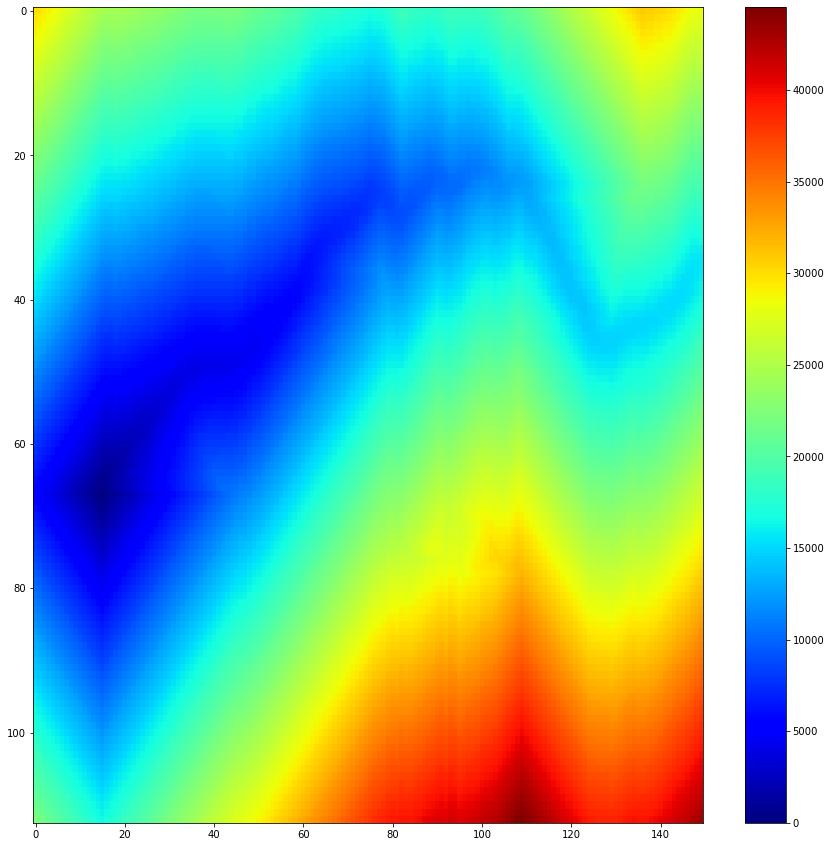

In [7]:
dist_matrix, prev_pxl = dijkstra(threshold_mountain, C, ridge_start_row, ridge_start_col)
fig, ax = plt.subplots()
img1 = ax.imshow(dist_matrix, cmap='jet')
fig.colorbar(img1, ax=ax)
ax.set_aspect('auto')

### Ridge Delineation

* Now use the matrix that stores previous pixel positions in the shortest paths to the starting point to reconstruct the path form the end point back to the starting point. 

In [17]:
def findRidge(ridge_start_row,ridge_start_col, ridge_end_row, ridge_end_col,parents):
    # Start from the end coordinates of the ridge
    ridge = []
    curr = [ridge_end_row, ridge_end_col]
    ridge.append(curr)
    
    # Backtract along the ridge until reach the beginning coordinates of the ridge
    while((curr[0] != ridge_start_row) and (curr[1] != ridge_start_col)):
        prev_row = parents[curr[0], curr[1], 0]
        prev_col = parents[curr[0], curr[1], 1]
        curr = [prev_row, prev_col]
        ridge.append(curr)
    
    return ridge

* Visualize the recovered path by overlaying it on the image

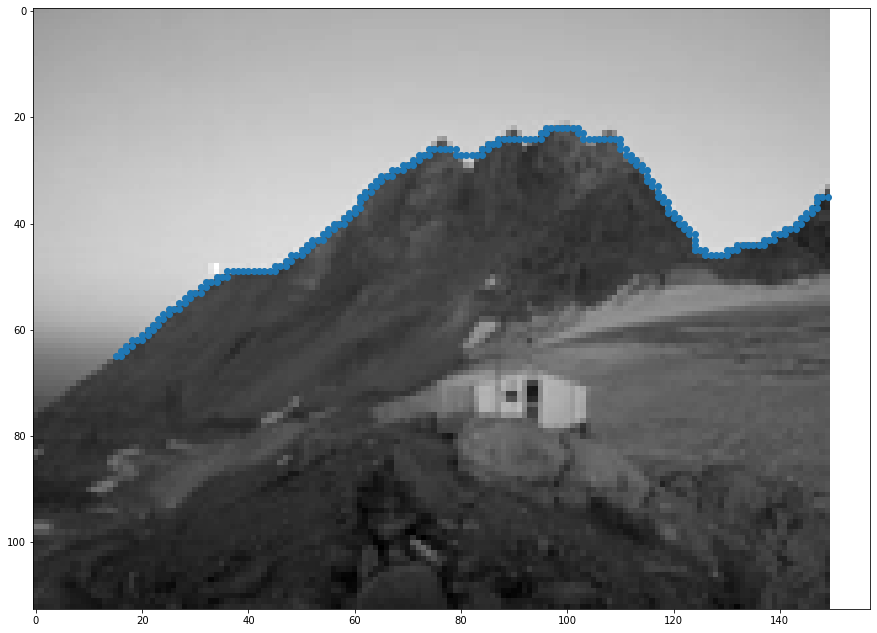

In [23]:
ridge_end_row = 35
ridge_end_col = 149
extracted_ridge=findRidge(ridge_start_row,ridge_start_col,ridge_end_row,ridge_end_col,prev_pxl.astype("int"))

plt.imshow(mountain)
plt.scatter([i[1] for i in extracted_ridge], [i[0] for i in extracted_ridge])

### Evaluating the edge cost

* Try different values of $C$ in Dijkstra algorithm. Visualize the distance matrix and the detected ridge for given $C$ values. How does the distance and the final detected ridge change? Do you understand why? 

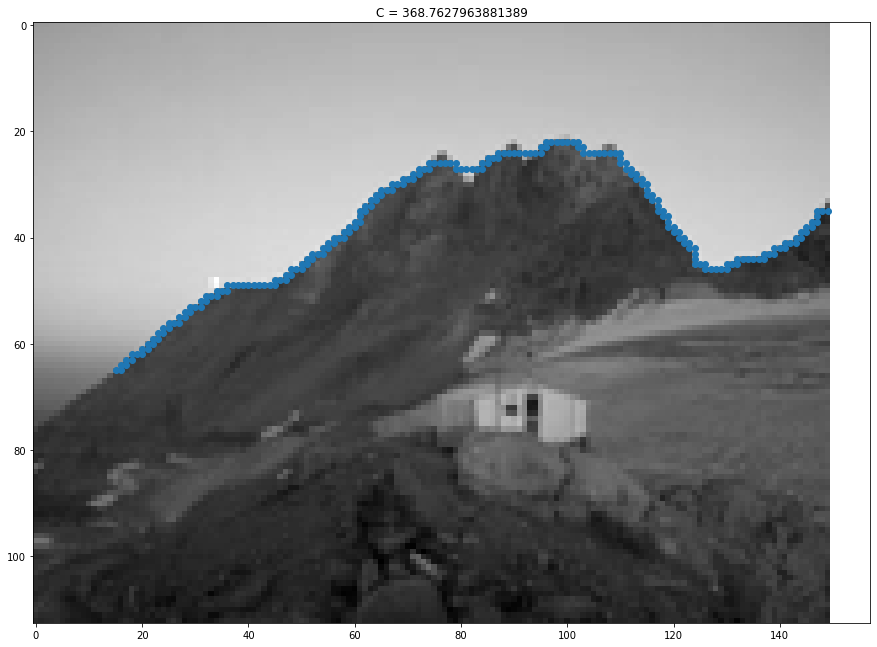

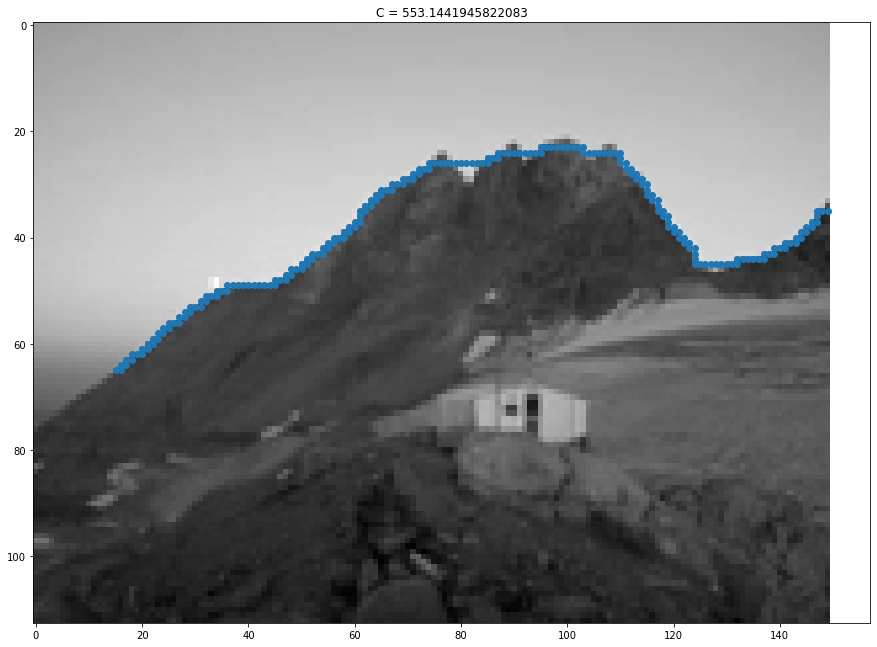

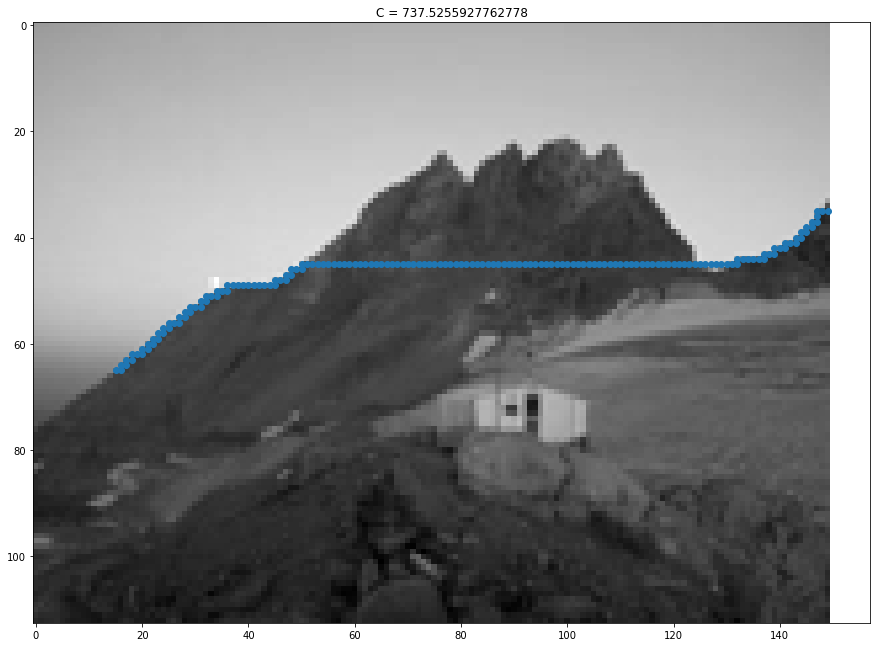

In [28]:
constants = [np.max(threshold_mountain), 1.5*np.max(threshold_mountain), 2*np.max(threshold_mountain)]

for C in constants:
    dist_matrix, prev_pxl = dijkstra(threshold_mountain, C, ridge_start_row, ridge_start_col)
    extracted_ridge=findRidge(ridge_start_row,ridge_start_col,ridge_end_row,ridge_end_col,prev_pxl.astype("int"))
    plt.show()
    plt.imshow(mountain)
    plt.scatter([i[1] for i in extracted_ridge], [i[0] for i in extracted_ridge])
    plt.title("C = " + str(C))